In [ ]:
#pip install category_encoders

In [37]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import log_loss, make_scorer

# Train

In [3]:
train = pd.read_csv('Train_TP2_Datos_2020-2C.csv')

In [3]:
train.shape

(16947, 52)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16947 entries, 0 to 16946
Data columns (total 52 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  16947 non-null  int64  
 1   Region                              16947 non-null  object 
 2   Territory                           16947 non-null  object 
 3   Pricing, Delivery_Terms_Quote_Appr  16947 non-null  int64  
 4   Pricing, Delivery_Terms_Approved    16947 non-null  int64  
 5   Bureaucratic_Code_0_Approval        16947 non-null  int64  
 6   Bureaucratic_Code_0_Approved        16947 non-null  int64  
 7   Submitted_for_Approval              16947 non-null  int64  
 8   Bureaucratic_Code                   16947 non-null  object 
 9   Account_Created_Date                16947 non-null  object 
 10  Source                              16947 non-null  object 
 11  Billing_Country                     16947

In [4]:
train = train[(train.Stage == 'Closed Won') | (train.Stage == 'Closed Lost')]
train['Stage'] = train['Stage'].transform(func=lambda x : 1 if x=='Closed Won' else 0)

In [5]:
#NO USAR NUMERO DE CONRATO PARA PREDECIR Sales_Contract_No
#porque si hay numero de contrato, quiere decir que hubo oportunidad con exito.....
train = train.drop('Sales_Contract_No', axis=1)

In [6]:
train = train.select_dtypes(['int64','float64']) 

In [7]:
train = train.drop('ID', axis=1)

In [52]:
train = train.drop('Pricing, Delivery_Terms_Quote_Appr', axis=1)
train = train.drop('Pricing, Delivery_Terms_Approved', axis=1)
train = train.drop('Bureaucratic_Code_0_Approved', axis=1)
train = train.drop('Bureaucratic_Code_0_Approval', axis=1)

In [12]:
train = train.drop('ID', axis=1)
train = train.drop('Territory', axis=1)
#train = train.drop('Pricing, Delivery_Terms_Quote_Appr', axis=1)
train = train.drop('Account_Name', axis=1)
train = train.drop('Opportunity_Name', axis=1)
train = train.drop('Account_Owner', axis=1)
train = train.drop('Opportunity_Owner', axis=1)
train = train.drop('Account_Type', axis=1)
train = train.drop('Opportunity_Type', axis=1)
train = train.drop('Quote_Type', axis=1)
train = train.drop('Delivery_Terms', axis=1)
#train = train.drop('Opportunity_Created_Date', axis=1)
train = train.drop('Brand', axis=1)
train = train.drop('Product_Type', axis=1)
train = train.drop('Size', axis=1)
train = train.drop('Product_Category_B', axis=1)
train = train.drop('Price', axis=1)
train = train.drop('Currency', axis=1)
train = train.drop('Last_Activity', axis=1)
train = train.drop('Quote_Expiry_Date', axis=1)
train = train.drop('Last_Modified_Date', axis=1)
train = train.drop('Last_Modified_By', axis=1)
train = train.drop('Product_Family', axis=1)
train = train.drop('Product_Name', axis=1)
train = train.drop('ASP_Currency', axis=1)
train = train.drop('ASP', axis=1)
train = train.drop('ASP_(converted)_Currency', axis=1)
train = train.drop('ASP_(converted)', axis=1)
train = train.drop('Planned_Delivery_Start_Date', axis=1)
train = train.drop('Planned_Delivery_End_Date', axis=1)
train = train.drop('Month', axis=1)
train = train.drop('Delivery_Quarter', axis=1)
train = train.drop('Delivery_Year', axis=1)
train = train.drop('Actual_Delivery_Date', axis=1)
train = train.drop('Total_Amount_Currency', axis=1)
train = train.drop('Total_Amount', axis=1)
train = train.drop('Total_Taxable_Amount_Currency', axis=1)
train = train.drop('Total_Taxable_Amount', axis=1)
train = train.drop('Prod_Category_A', axis=1)
train = train.drop('Submitted_for_Approval', axis=1)
train = train.drop('Bureaucratic_Code', axis=1)
train = train.drop('Region', axis=1)

---

In [8]:
train['TRF_promedio'] = train.groupby('Opportunity_ID')['TRF'].transform('mean')
train = train.drop('TRF', axis=1)

In [9]:
train = train.drop_duplicates('Opportunity_ID')
train = train.drop('Opportunity_ID', axis=1)

In [55]:
train.shape

(9791, 8)

In [10]:
train_label = train['Stage']
train_data = train.iloc[:, train.columns != 'Stage']
print(train_label.shape,train_data.shape)

(9791,) (9791, 11)


In [11]:
X, y = train.iloc[:, train.columns != 'Stage'],train.loc[:,['Stage']]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=123)

HIPERPARAMETROS

learning_rate: tasa de aprendizaje
max_depth: máxima profundidad de cada árbol
subsample: porcentaje de muestras usadas para cada árbol (valor muy bajo, posible underfitting)
colsample_bytree: porcentaje de features usadas para cada árbol (valores muy alto, posible overfitting)
n_estimators: cantidad de árboles a construir.
objective: función de error a utilizar (algunas: reg:squarederror para regresión, reg:logistic o binary:logistic para clasificación)
Parámetros de regularización:

gamma: umbral para hacer split basado en la reducción de error de hacer el nuevo split.
alpha: regularización para los pesos de las hojas. Un valor más alto genera una mayor regularización.
lambda: similar alpha pero para la sintonia fina.

In [49]:
#INSTANCIO XGBOOST REGRESSOR
xg_reg = xgb.XGBRegressor(objective ='reg:squaredlogerror', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 15, n_estimators = 10,eval_metric=log_loss)
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=15, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3,
             eval_metric=<function log_loss at 0x000001E6BECE94C8>, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=8, num_parallel_tree=1,
             objective='reg:squaredlogerror', random_state=0, reg_alpha=15,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [50]:
preds = xg_reg.predict(X_test)
rmsle = log_loss(y_test, preds)
print("RMSLE: %f" % (rmsle))

RMSLE: 0.598146


In [14]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [55]:
params = {"objective":"reg:logistic",'colsample_bytree': 0.3,
          'learning_rate': 0.1, 'max_depth': 5, 'alpha': 15}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="logloss", as_pandas=True, seed=123)

In [56]:
cv_results.head()

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.690252,0.000160,0.690477,0.000156
1,0.672836,0.002638,0.673582,0.002383
2,0.661227,0.008611,0.662488,0.008045
3,0.645248,0.008098,0.646892,0.007400
4,0.634752,0.010218,0.636866,0.009560


In [57]:
print((cv_results["test-logloss-mean"]).tail(1))

49    0.517247
Name: test-logloss-mean, dtype: float64


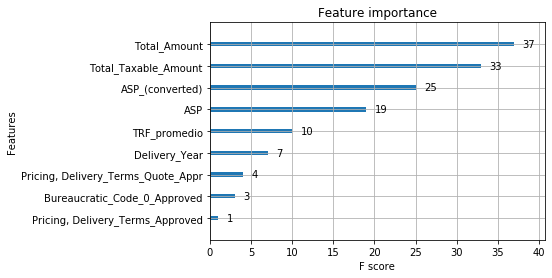

<Figure size 1152x864 with 0 Axes>

In [18]:
xgb.plot_importance(xg_reg)
plt.figure(figsize = (16, 12))
plt.show()

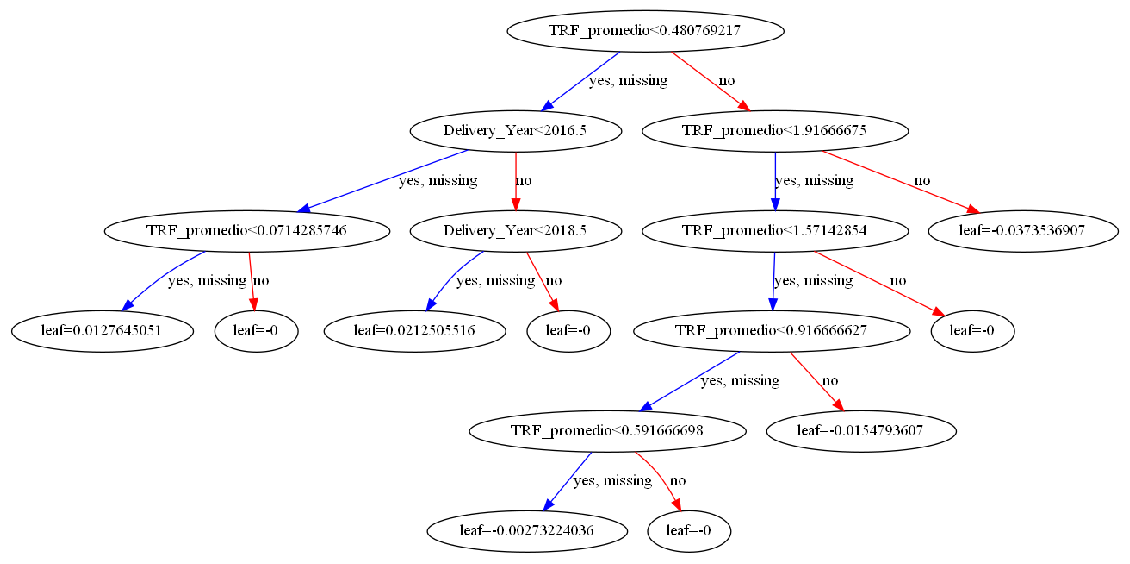

In [65]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
plt.rcParams['figure.figsize'] = [20, 20]
xgb.plot_tree(xg_reg,num_trees=0)

# Test

In [29]:
test = pd.read_csv('Test_TP2_Datos_2020-2C.csv')

In [30]:
test = test.drop('Sales_Contract_No', axis=1)

In [21]:
test = test.select_dtypes(['int64','float64']) 

In [22]:
test = test.drop('ID', axis=1)

In [15]:
test = test.drop('ID', axis=1)
#test = test.drop('Territory', axis=1)
test = test.drop('Pricing, Delivery_Terms_Quote_Appr', axis=1)
test = test.drop('Pricing, Delivery_Terms_Approved', axis=1)
test = test.drop('Bureaucratic_Code_0_Approval', axis=1)
test = test.drop('Bureaucratic_Code_0_Approved', axis=1)
test = test.drop('Account_Created_Date', axis=1)
#test = test.drop('Source ', axis=1)
test = test.drop('Billing_Country', axis=1)
#test = test.drop('Account_Name', axis=1)
test = test.drop('Opportunity_Name', axis=1)
test = test.drop('Account_Owner', axis=1)
#test = test.drop('Opportunity_Owner', axis=1)
test = test.drop('Account_Type', axis=1)
test = test.drop('Opportunity_Type', axis=1)
test = test.drop('Quote_Type', axis=1)
test = test.drop('Delivery_Terms', axis=1)
test = test.drop('Opportunity_Created_Date', axis=1)
test = test.drop('Brand', axis=1)
test = test.drop('Product_Type', axis=1)
test = test.drop('Size', axis=1)
test = test.drop('Product_Category_B', axis=1)
test = test.drop('Price', axis=1)
test = test.drop('Currency', axis=1)
test = test.drop('Last_Activity', axis=1)
test = test.drop('Quote_Expiry_Date', axis=1)
test = test.drop('Last_Modified_Date', axis=1)
test = test.drop('Last_Modified_By', axis=1)
test = test.drop('Product_Family', axis=1)
test = test.drop('Product_Name', axis=1)
test = test.drop('ASP_Currency', axis=1)
test = test.drop('ASP', axis=1)
test = test.drop('ASP_(converted)_Currency', axis=1)
test = test.drop('ASP_(converted)', axis=1)
test = test.drop('Planned_Delivery_Start_Date', axis=1)
test = test.drop('Planned_Delivery_End_Date', axis=1)
test = test.drop('Month', axis=1)
test = test.drop('Delivery_Quarter', axis=1)
test = test.drop('Delivery_Year', axis=1)
test = test.drop('Actual_Delivery_Date', axis=1)
test = test.drop('Total_Amount_Currency', axis=1)
test = test.drop('Total_Amount', axis=1)
test = test.drop('Total_Taxable_Amount_Currency', axis=1)
test = test.drop('Total_Taxable_Amount', axis=1)
test = test.drop('Prod_Category_A', axis=1)
test = test.drop('Submitted_for_Approval', axis=1)
test = test.drop('Bureaucratic_Code', axis=1)
test = test.drop('Region', axis=1)

---

In [23]:
test['TRF_promedio'] = test.groupby('Opportunity_ID')['TRF'].transform('mean')
test = test.drop('TRF', axis=1)

---

In [32]:
test = test.drop_duplicates('Opportunity_ID')
IDs = test[['Opportunity_ID']].copy()
test = test.drop('Opportunity_ID', axis=1)

---

# Modelos

In [25]:
#INSTANCIO XGBOOST REGRESSOR
xg_reg = xgb.XGBRegressor(objective ='reg:squaredlogerror', 
                colsample_bytree = 0.2, learning_rate = 0.1,
                max_depth = 4, alpha = 50, n_estimators = 10)
xg_reg.fit(train_data,train_label)
preds = xg_reg.predict(test)

In [26]:
entregable_RFC = IDs[['Opportunity_ID']].copy()
entregable_RFC['Target'] = preds

In [27]:
entregable_RFC

,Opportunity_ID,Target
0,10689,0.523409
3,10690,0.477769
8,10691,0.592709
9,10692,0.419267
15,10693,0.599801
...,...,...
2545,12364,0.562343
2547,12365,0.592709
2548,12366,0.591858
2549,12367,0.543365


In [28]:
entregable_RFC.to_csv('Test_XGBoostSoloNumericos.csv', index=False)